Clean the smiles from Colin et al's csv files from v1.0.1: https://zenodo.org/record/3715478#.YFfpgh0pDUI

In [1]:
import copy
import pandas as pd

from rmgpy.molecule.molecule import *
from rmgpy.species import Species
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import AtomValenceException
from rdkit.Geometry import Point3D
from rdkit.six import StringIO
from typing import List, Tuple, Union

from arc.species import ARCSpecies
from arc.reaction import ARCReaction

from arc.species.converter import (check_isomorphism,
                                   molecules_from_xyz,
                                   str_to_xyz,
                                   xyz_to_str,
                                   xyz_to_x_y_z,
                                   xyz_to_xyz_file_format,
                                   xyz_to_dmat,
                                   xyz_to_coords_list,
                                  )
from arc.parser import parse_xyz_from_file
from IPython.display import display
import arc
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Define helper functions

In [2]:
def look_for_adjacent_charges(smiles, idx):
    # create mol from original smiles
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # set label on H atoms
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    
    index_str = f'{idx:06}'  # convert to formatted string
    if out != 0:
        print(f'ERROR: Could not embed reactant for rxn {index_str}: {smiles} !!!!!!!\n')
        failed_embedding_idx.append(index_str)
    
    for i, b in enumerate(mol.GetBonds()):
        ac1 = b.GetBeginAtom().GetFormalCharge()
        ac2 = b.GetEndAtom().GetFormalCharge()
        
        # skip triple bonds as these are often carbenes, whose resonance structure is better represented as N+ and C-
        if b.GetBondType() == Chem.BondType.TRIPLE:
            continue
        
        # detects radical electrons or formal charges on neighboring atoms    
        if (abs(ac1) + abs(ac2) == 2) and (ac1 + ac2 == 0) :
            
            b.GetBeginAtom().SetFormalCharge(0)
            b.GetEndAtom().SetFormalCharge(0)
            new_mol = Chem.EditableMol(mol)  # an editable molecule class
            # RW molecule class (read/write)
            # This class is a more-performant version of the EditableMolecule class in that it is a ‘live’ molecule and shares the interface from the Mol class. 
            # All changes are performed without the need to create a copy of the molecule using GetMol()
            # new_mol = Chem.RWMol(mol) 
            
            a1 = b.GetBeginAtomIdx()
            a2 = b.GetEndAtomIdx()
            new_mol.RemoveBond(a1, a2)
            new_mol.AddBond(a1, a2, Chem.BondType.DOUBLE)

            new_mol = new_mol.GetMol()
            # set label on H atoms
            # print([a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()])
            # [a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()]
            new_smi = Chem.MolToSmiles(new_mol)
            
            # use try except to catch valence errors, such as assigning 5 bonds to N
            try:
                new_mol.UpdatePropertyCache()
            except Exception as e:
                continue
                
            print(f'rxn {index_str} with smiles {smiles} had neighboring formal charges')
            display(mol)
            
            print(f'Propose adding a double bond instead as {new_smi}')
            display(new_mol)
            print('*'*90)
            
            return idx

In [3]:
wb97xd3 = 'wb97xd3_original.csv'
df_colin = pd.read_csv(wb97xd3)
df_colin

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...,74.207878,25.357506
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656628,12.050720
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,76.830279,22.023014
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]([C...,72.185427,-4.896952
...,...,...,...,...,...
11956,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2][C:4]([O:5][C:6](=[O:7])[H:15])([H:...,76.498542,71.925276
11957,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]1([H:11])[O:3][C@:6]([O:7][H:12])...,43.743167,6.397510
11958,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]([O:3][H:12])([C:4](=[O:5])[H:14]...,73.601660,27.552744
11959,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,66.621537,13.289960


In [4]:
df_colin.psmi.unique().shape

(11905,)

In [5]:
df_colin_unique = df_colin.drop_duplicates(subset=['psmi'])
df_colin_unique

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...,74.207878,25.357506
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656628,12.050720
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,76.830279,22.023014
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]([C...,72.185427,-4.896952
...,...,...,...,...,...
11956,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2][C:4]([O:5][C:6](=[O:7])[H:15])([H:...,76.498542,71.925276
11957,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]1([H:11])[O:3][C@:6]([O:7][H:12])...,43.743167,6.397510
11958,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]([O:3][H:12])([C:4](=[O:5])[H:14]...,73.601660,27.552744
11959,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,66.621537,13.289960


In [84]:
# work in increments of 1000 reactions
# ignore molecules that cannot be kekulized
start = 12000
failed_embedding_idx = []
for i, psmi in enumerate(df_colin_unique.psmi.values[start:]): # start+1000
    i += start
    
    # only look at reactions with 1 product
    num_products = len(psmi.split('.'))
    if num_products == 1:
        idx = df_colin_unique.idx.values[i]
        look_for_adjacent_charges(psmi, idx)

Verify that RDKit preserved the atom mapping in the new SMILES

In [8]:
def create_rdkit_mol(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    mol = Chem.AddHs(mol)
    # out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    display(mol)
    
    return mol

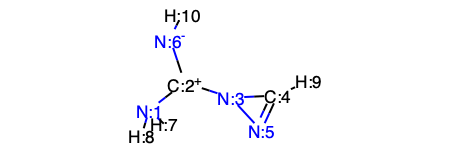

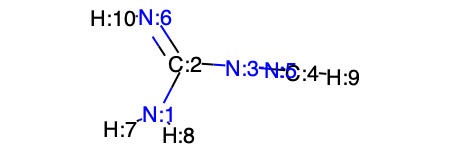

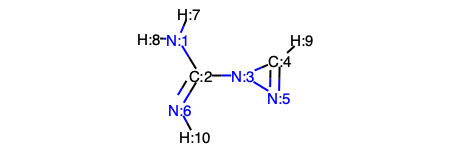

In [27]:
# rxn000367. 485 in b97d3
# original
smiles = '[N:1]([C+:2]([N:3]1[C:4]([H:9])=[N:5]1)[N-:6][H:10])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was actually correct!
smiles = '[N:1]([C:2]([N:3]1[C:4]([H:9])=[N:5]1)=[N:6][H:10])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2]([N:3]1[C:4]([H:9])=[N:5]1)=[N:6][H:10])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

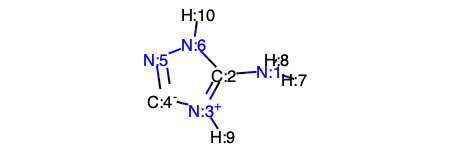

RDKit ERROR: [22:17:13] Can't kekulize mol.  Unkekulized atoms: 1 3 4
RDKit ERROR: 


ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)

In [28]:
# 000371. do NOT change this one
# original
smiles = '[N:1]([c:2]1[n+:3]([H:9])[c-:4][n:5][n:6]1[H:10])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was actually correct!
smiles = '[N:1]([c:2]1[n:3]([H:9])=[c:4][n:5][n:6]1[H:10])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([c:2]1[n+:3]([H:9])[c-:4][n:5][n:6]1[H:10])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

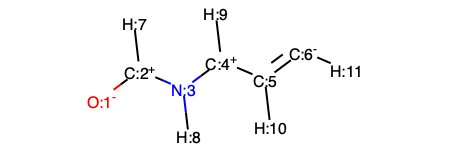

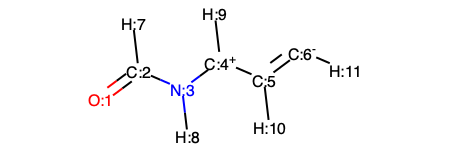

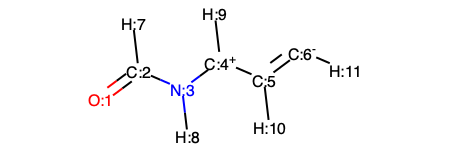

In [31]:
# rxn000632
# original
smiles = '[O-:1][C+:2]([N:3]([C+:4]([C:5](=[C-:6][H:11])[H:10])[H:9])[H:8])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was actually correct!
smiles = '[O:1]=[C:2]([N:3]([C+:4]([C:5](=[C-:6][H:11])[H:10])[H:9])[H:8])[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]=[C:2]([N:3]([C+:4]([C:5](=[C-:6][H:11])[H:10])[H:9])[H:8])[H:7]'
mol3 = create_rdkit_mol(smiles)

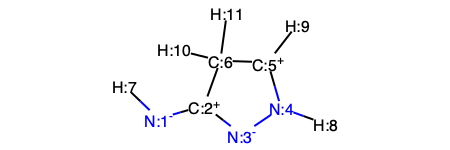

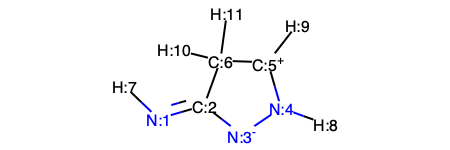

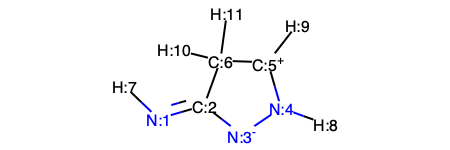

In [21]:
# rxn000913
# original
smiles = '[N-:1]([C+:2]1[N-:3][N:4]([H:9])[C+:5]([H:10])[C:6]1([H:7])[H:11])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, incorrect atom map for Hs!
smiles = '[N:1](=[C:2]1[N-:3][N:4]([H:8])[C+:5]([H:9])[C:6]1([H:10])[H:11])[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1](=[C:2]1[N-:3][N:4]([H:9])[C+:5]([H:10])[C:6]1([H:7])[H:11])[H:8]'
mol3 = create_rdkit_mol(smiles)

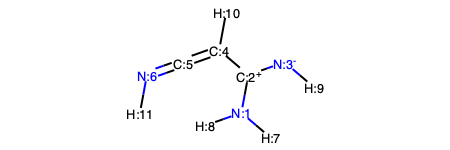

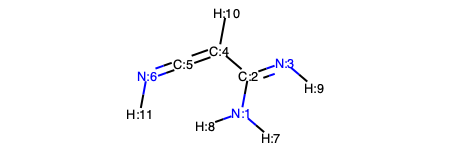

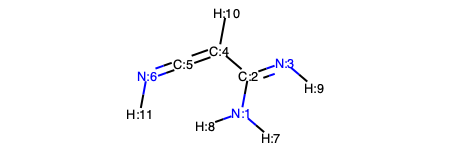

In [23]:
# rxn000921
# original
smiles = '[N:1]([C+:2]([N-:3][H:10])[C:6](=[C:5]=[N:4][H:9])[H:11])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, incorrect H atom mapping!
smiles = '[N:1]([C:2](=[N:3][H:9])[C:4](=[C:5]=[N:6][H:11])[H:10])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2](=[N:3][H:10])[C:6](=[C:5]=[N:4][H:9])[H:11])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

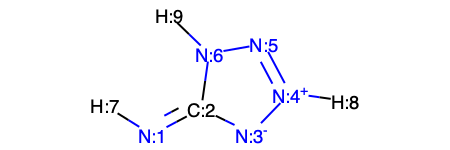

RDKit ERROR: [22:15:24] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)

In [24]:
#  did NOT accept this change
# original
smiles = '[N:1](=[c:2]1[n-:3][n+:4]([H:9])[n:5][n:6]1[H:8])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was actually correct!
smiles = '[N:1](=[c:2]1[n:3]=[n:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1](=[c:2]1[n-:3][n+:4]([H:9])[n:5][n:6]1[H:8])[H:7]'
mol3 = create_rdkit_mol(smiles)

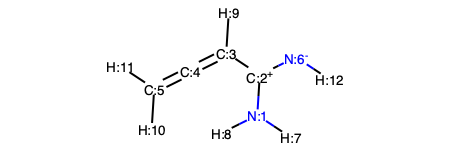

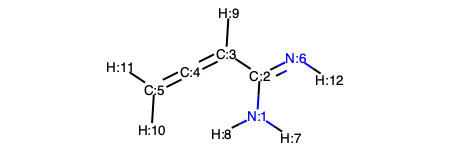

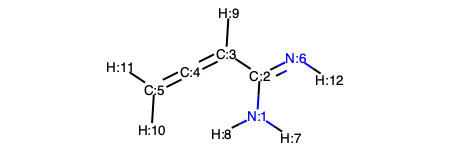

In [33]:
# rxn001076
# original
smiles = '[N:1]([C+:2]([C:3](=[C:4]=[C:5]([H:10])[H:11])[H:9])[N-:6][H:12])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was actually correct!
smiles = '[N:1]([C:2]([C:3](=[C:4]=[C:5]([H:10])[H:11])[H:9])=[N:6][H:12])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2]([C:3](=[C:4]=[C:5]([H:10])[H:11])[H:9])=[N:6][H:12])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

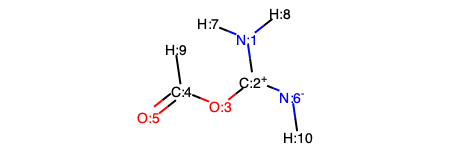

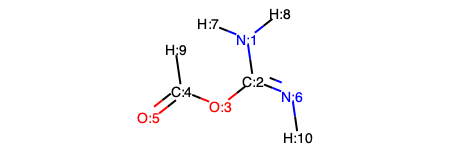

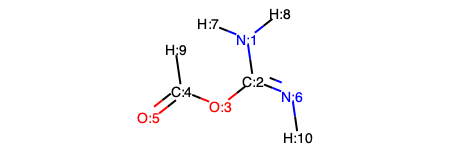

In [85]:
# rxn001088
# original
smiles = '[N:1]([C+:2]([O:3][C:5](=[O:6])[H:10])[N-:4][H:9])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, atom mapping was incorrect!
smiles = '[N:1]([C:2]([O:3][C:4](=[O:5])[H:9])=[N:6][H:10])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2]([O:3][C:5](=[O:6])[H:10])=[N:4][H:9])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

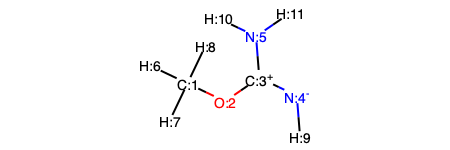

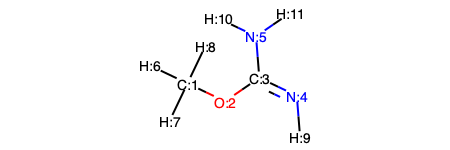

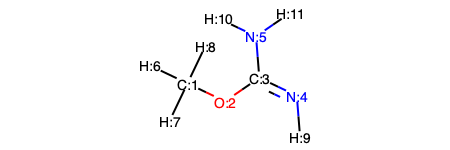

In [87]:
# rxn00003345
# original
smiles = '[C:1]([O:4][C+:3]([N-:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, atom mapping was wrong!
smiles = '[C:1]([O:2][C:3](=[N:4][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[C:1]([O:4][C:3](=[N:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

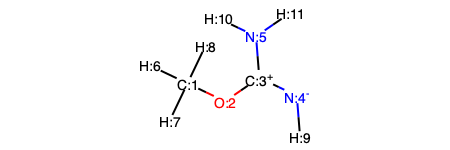

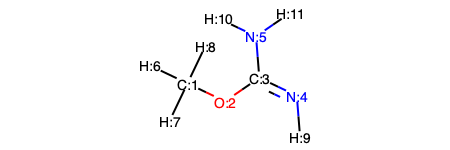

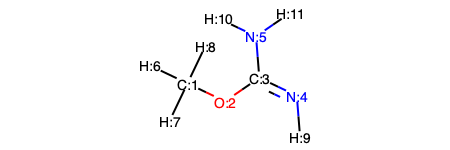

In [64]:
# rxn003345
# original
smiles = '[C:1]([O:4][C+:3]([N-:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect!
smiles = '[C:1]([O:2][C:3](=[N:4][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[C:1]([O:4][C:3](=[N:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

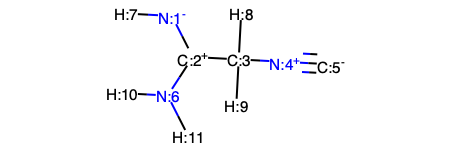

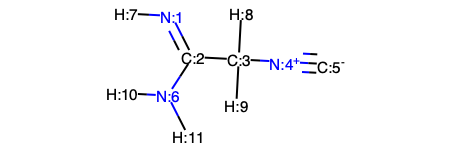

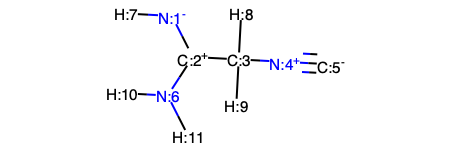

In [65]:
# rxn003995
# original
smiles = '[N-:1]([C+:2]([C:3]([N+:4]#[C-:5])([H:8])[H:9])[N:6]([H:10])[H:11])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[N:1](=[C:2]([C:3]([N+:4]#[C-:5])([H:8])[H:9])[N:6]([H:10])[H:11])[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N-:1]([C+:2]([C:3]([N+:4]#[C-:5])([H:8])[H:9])[N:6]([H:10])[H:11])[H:7]'
mol3 = create_rdkit_mol(smiles)

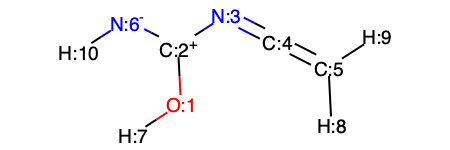

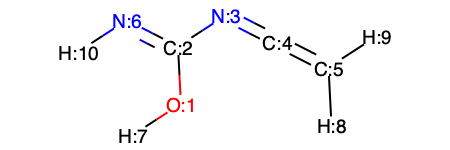

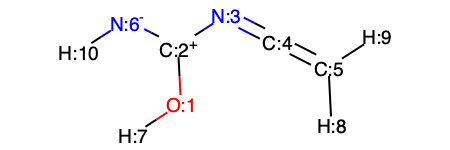

In [67]:
# rxn004307
# original
smiles = '[O:1]([C+:2]([N:3]=[C:4]=[C:5]([H:8])[H:9])[N-:6][H:10])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[O:1]([C:2]([N:3]=[C:4]=[C:5]([H:8])[H:9])=[N:6][H:10])[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([C+:2]([N:3]=[C:4]=[C:5]([H:8])[H:9])[N-:6][H:10])[H:7]'
mol3 = create_rdkit_mol(smiles)

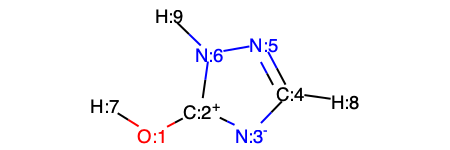

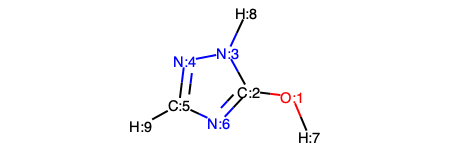

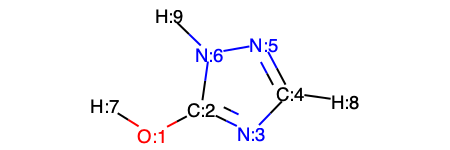

In [69]:
# rxn004626
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect!
smiles = '[O:1]([c:2]1[n:6]([H:9])[n:5][c:4]([H:8])[n:3]=1)[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol3 = create_rdkit_mol(smiles)

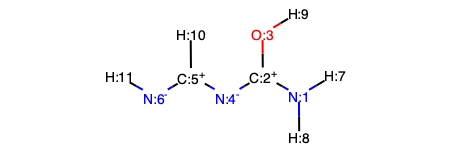

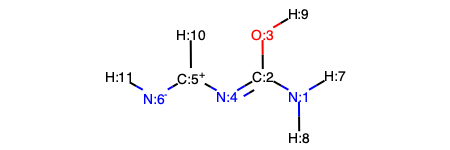

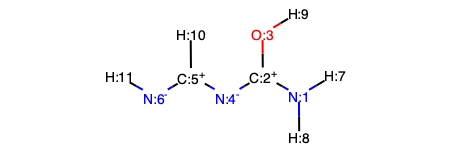

In [70]:
# rxn004746
# original
smiles = '[N:1]([C+:2]([O:3][H:9])[N-:4][C+:5]([N-:6][H:11])[H:10])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[N:1]([C:2]([O:3][H:9])=[N:4][C+:5]([N-:6][H:11])[H:10])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C+:2]([O:3][H:9])[N-:4][C+:5]([N-:6][H:11])[H:10])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

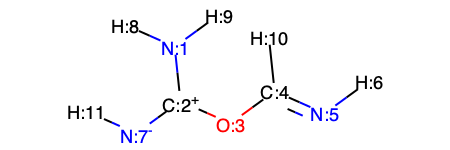

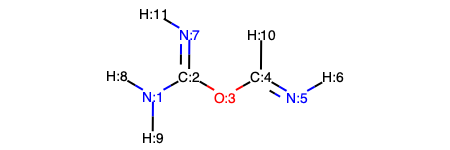

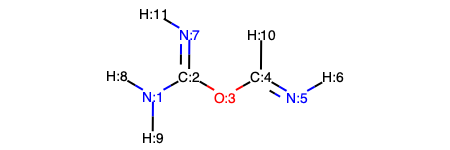

In [76]:
# rxn004747
# original
smiles = '[N:1]([C+:2]([O:3]/[C:5](=[N:6]/[H:11])[H:10])[N-:4][H:9])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect!
smiles = '[N:1]([C:2]([O:3]/[C:4](=[N:5]/[H:6])[H:10])=[N:7][H:11])([H:8])[H:9]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2]([O:3]/[C:5](=[N:6]/[H:11])[H:10])=[N:4][H:9])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

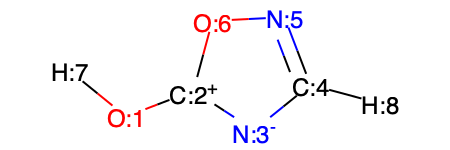

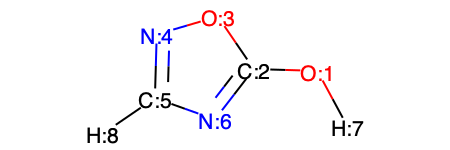

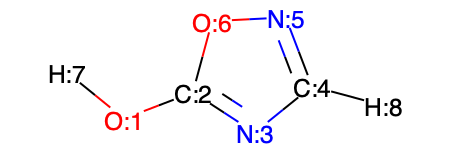

In [82]:
# rxn005148
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][o:6]1)[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect!
smiles = '[O:1]([c:2]1[o:6][n:5][c:4]([H:8])[n:3]=1)[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([H:8])[n:5][o:6]1)[H:7]'
mol3 = create_rdkit_mol(smiles)

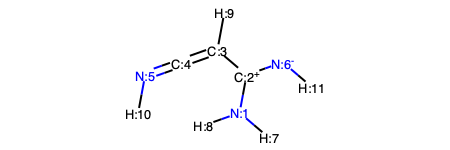

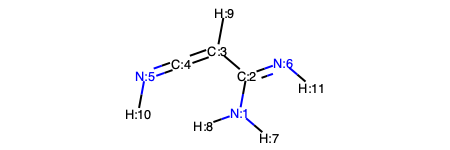

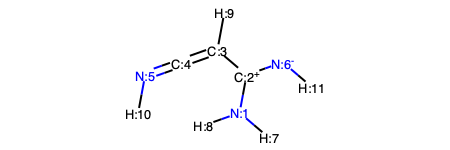

In [83]:
# rxn005388
# original
smiles = '[N:1]([C+:2]([C:3](=[C:4]=[N:5][H:10])[H:9])[N-:6][H:11])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[N:1]([C:2]([C:3](=[C:4]=[N:5][H:10])[H:9])=[N:6][H:11])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C+:2]([C:3](=[C:4]=[N:5][H:10])[H:9])[N-:6][H:11])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

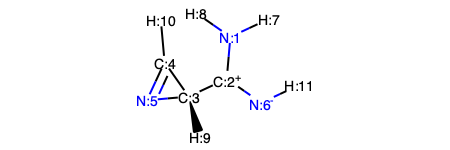

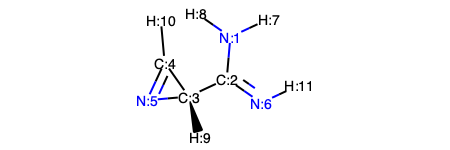

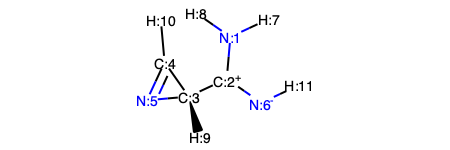

In [84]:
# rxn005395
# original
smiles = '[N:1]([C+:2]([C@@:3]1([H:9])[C:4]([H:10])=[N:5]1)[N-:6][H:11])([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[N:1]([C:2]([C@@:3]1([H:9])[C:4]([H:10])=[N:5]1)=[N:6][H:11])([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C+:2]([C@@:3]1([H:9])[C:4]([H:10])=[N:5]1)[N-:6][H:11])([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

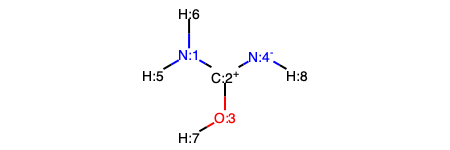

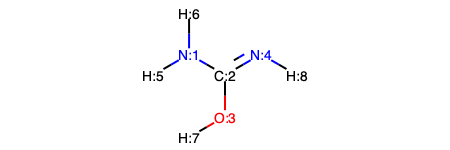

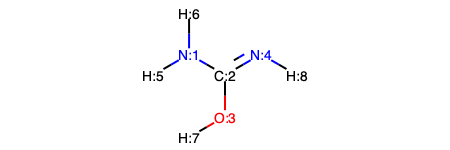

In [86]:
# rxn005826
# original
smiles = '[N:1]([C+:2]([O:3][H:8])[N-:4][H:7])([H:5])[H:6]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect! H atoms
smiles = '[N:1]([C:2]([O:3][H:7])=[N:4][H:8])([H:5])[H:6]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([C:2]([O:3][H:8])=[N:4][H:7])([H:5])[H:6]'
mol3 = create_rdkit_mol(smiles)

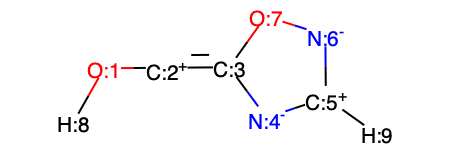

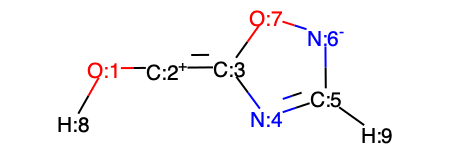

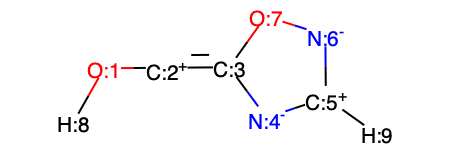

In [88]:
# rxn006703
# original
smiles = '[O:1]([C+:2]=[C:3]1[N-:4][C+:5]([H:9])[N-:6][O:7]1)[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[O:1]([C+:2]=[C:3]1[N:4]=[C:5]([H:9])[N-:6][O:7]1)[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([C+:2]=[C:3]1[N-:4][C+:5]([H:9])[N-:6][O:7]1)[H:8]'
mol3 = create_rdkit_mol(smiles)

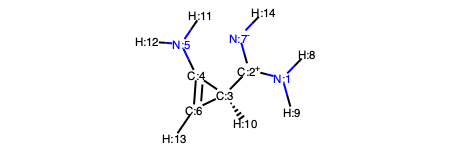

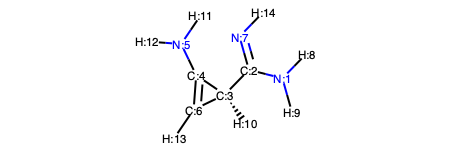

In [88]:
# rxn006921
# original
smiles = '[N:1]([C+:2]([C@:3]1([H:10])[C:4]([N:5]([H:11])[H:12])=[C:6]1[H:13])[N-:7][H:14])([H:8])[H:9]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct!
smiles = '[N:1]([C:2]([C@:3]1([H:10])[C:4]([N:5]([H:11])[H:12])=[C:6]1[H:13])=[N:7][H:14])([H:8])[H:9]'
mol2 = create_rdkit_mol(smiles)

# # cleaned
# smiles = '[N:1]([C+:2]([C@:3]1([H:10])[C:4]([N:5]([H:11])[H:12])=[C:6]1[H:13])[N-:7][H:14])([H:8])[H:9]'
# mol3 = create_rdkit_mol(smiles)

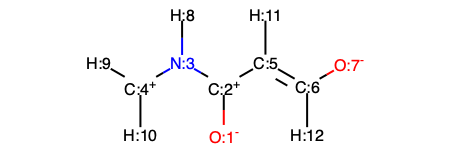

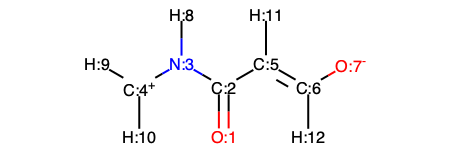

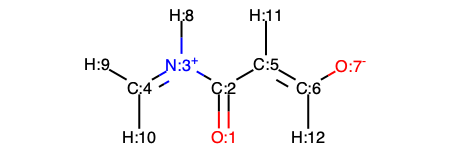

In [12]:
# rxn007067
# original
smiles = '[O-:1][C+:2]([N:3]([C+:4]([H:9])[H:10])[H:8])[C:7](=[C:5]([O-:6])[H:11])[H:12]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect! atom mapping is wrong in smiles
smiles = '[O:1]=[C:2]([N:3]([C+:4]([H:9])[H:10])[H:8])[C:5](=[C:6]([O-:7])[H:12])[H:11]'
mol2 = create_rdkit_mol(smiles)

# cleaned. use best resonance structure
# https://rmg.mit.edu/database/resonance_structure/1%20%20O%20u0%20p3%20c-1%20%7B2,S%7D%0A2%20%20C%20u0%20p0%20c+1%20%7B1,S%7D%20%7B3,S%7D%20%7B8,S%7D%0A3%20%20N%20u0%20p1%20c0%20%7B2,S%7D%20%7B4,S%7D%20%7B7,S%7D%0A4%20%20C%20u0%20p0%20c+1%20%7B3,S%7D%20%7B5,S%7D%20%7B6,S%7D%0A5%20%20H%20u0%20p0%20c0%20%7B4,S%7D%0A6%20%20H%20u0%20p0%20c0%20%7B4,S%7D%0A7%20%20H%20u0%20p0%20c0%20%7B3,S%7D%0A8%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B9,D%7D%20%7B12,S%7D%0A9%20%20C%20u0%20p0%20c0%20%7B8,D%7D%20%7B10,S%7D%20%7B11,S%7D%0A10%20O%20u0%20p3%20c-1%20%7B9,S%7D%0A11%20H%20u0%20p0%20c0%20%7B9,S%7D%0A12%20H%20u0%20p0%20c0%20%7B8,S%7D%0A
smiles = '[O:1]=[C:2]([N+:3](=[C:4]([H:9])[H:10])[H:8])[C:7](=[C:5]([O-:6])[H:11])[H:12]'
mol3 = create_rdkit_mol(smiles)

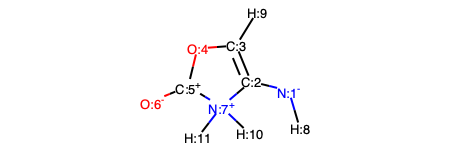

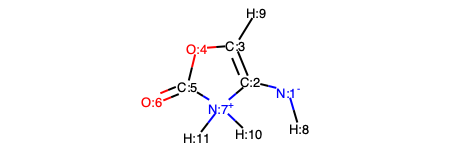

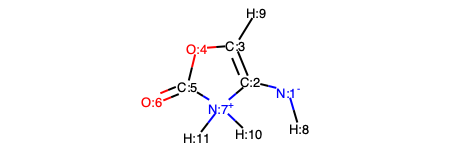

In [14]:
# rxn007330
# original
smiles = '[N-:1]([C:2]1=[C:3]([H:10])[O:4][C+:5]([O-:6])[N+:7]1([H:8])[H:11])[H:9]'
mol1 = create_rdkit_mol(smiles)

# proposed, was incorrect! atom mapping is wrong in smiles
smiles = '[N-:1]([C:2]1=[C:3]([H:9])[O:4][C:5](=[O:6])[N+:7]1([H:10])[H:11])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned. use best resonance structure
# https://rmg.mit.edu/database/resonance_structure/1%20%20N%20u0%20p2%20c-1%20%7B2,S%7D%20%7B11,S%7D%0A2%20%20C%20u0%20p0%20c0%20%7B1,S%7D%20%7B3,D%7D%20%7B8,S%7D%0A3%20%20C%20u0%20p0%20c0%20%7B2,D%7D%20%7B4,S%7D%20%7B5,S%7D%0A4%20%20H%20u0%20p0%20c0%20%7B3,S%7D%0A5%20%20O%20u0%20p2%20c0%20%7B3,S%7D%20%7B6,S%7D%0A6%20%20C%20u0%20p0%20c0%20%7B5,S%7D%20%7B7,D%7D%20%7B8,S%7D%0A7%20%20O%20u0%20p2%20c0%20%7B6,D%7D%0A8%20%20N%20u0%20p0%20c+1%20%7B2,S%7D%20%7B6,S%7D%20%7B9,S%7D%20%7B10,S%7D%0A9%20%20H%20u0%20p0%20c0%20%7B8,S%7D%0A10%20H%20u0%20p0%20c0%20%7B8,S%7D%0A11%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
smiles = '[N-:1]([C:2]1=[C:3]([H:10])[O:4][C:5](=[O:6])[N+:7]1([H:8])[H:11])[H:9]'
mol3 = create_rdkit_mol(smiles)

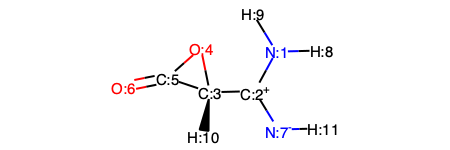

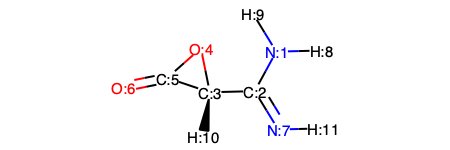

In [19]:
# rxn007340
# original
smiles = '[N:1]([C+:2]([C@@:3]1([H:10])[O:4][C:5]1=[O:6])[N-:7][H:11])([H:8])[H:9]'
mol1 = create_rdkit_mol(smiles)

# proposed, was correct atom mapping and the best resonance structure
# https://rmg.mit.edu/database/resonance_structure/1%20%20N%20u0%20p1%20c0%20%7B2,S%7D%20%7B10,S%7D%20%7B11,S%7D%0A2%20%20C%20u0%20p0%20c0%20%7B1,S%7D%20%7B3,S%7D%20%7B8,D%7D%0A3%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B4,S%7D%20%7B5,S%7D%20%7B6,S%7D%0A4%20%20H%20u0%20p0%20c0%20%7B3,S%7D%0A5%20%20O%20u0%20p2%20c0%20%7B3,S%7D%20%7B6,S%7D%0A6%20%20C%20u0%20p0%20c0%20%7B3,S%7D%20%7B5,S%7D%20%7B7,D%7D%0A7%20%20O%20u0%20p2%20c0%20%7B6,D%7D%0A8%20%20N%20u0%20p1%20c0%20%7B2,D%7D%20%7B9,S%7D%0A9%20%20H%20u0%20p0%20c0%20%7B8,S%7D%0A10%20H%20u0%20p0%20c0%20%7B1,S%7D%0A11%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
smiles = '[N:1]([C:2]([C@@:3]1([H:10])[O:4][C:5]1=[O:6])=[N:7][H:11])([H:8])[H:9]'
mol2 = create_rdkit_mol(smiles)

# # cleaned. 
# smiles = '[N:1]([C+:2]([C@@:3]1([H:10])[O:4][C:5]1=[O:6])[N-:7][H:11])([H:8])[H:9]'
# mol3 = create_rdkit_mol(smiles)

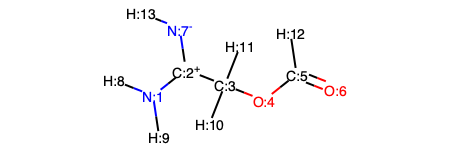

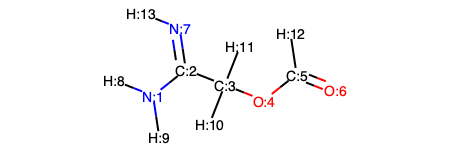

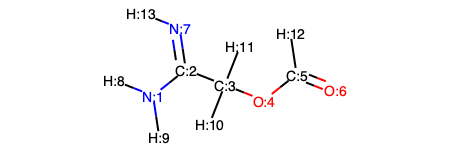

In [21]:
# rxn007859
# original
smiles = '[N:1]([C+:2]([C:4]([O:5][C:6](=[O:3])[H:12])([H:10])[H:11])[N-:7][H:13])([H:8])[H:9]'
mol1 = create_rdkit_mol(smiles)

# proposed, had incorrect atom mapping!
smiles = '[N:1]([C:2]([C:3]([O:4][C:5](=[O:6])[H:12])([H:10])[H:11])=[N:7][H:13])([H:8])[H:9]'
mol2 = create_rdkit_mol(smiles)

# cleaned. 
smiles = '[N:1]([C:2]([C:4]([O:5][C:6](=[O:3])[H:12])([H:10])[H:11])=[N:7][H:13])([H:8])[H:9]'
mol3 = create_rdkit_mol(smiles)

[N:1]([C+:2]([C:3]1([O:4][H:10])[C:5]([H:11])=[C:6]1[H:12])[N-:7][H:13])([H:8])[H:9]


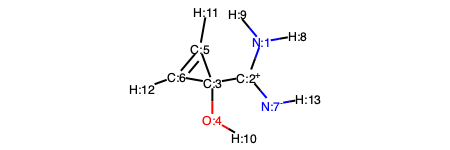

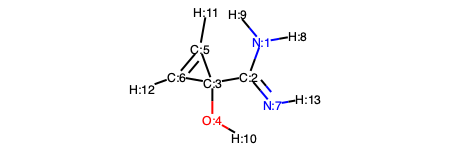

In [23]:
smiles = df_colin.psmi.values[8463]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[N:1]([C:2]([C:3]1([O:4][H:10])[C:5]([H:11])=[C:6]1[H:12])=[N:7][H:13])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

[N:1]([C+:2](/[C:3]([O:4][H:10])=[C:5](\[C:6][H:12])[H:11])[N-:7][H:13])([H:8])[H:9]


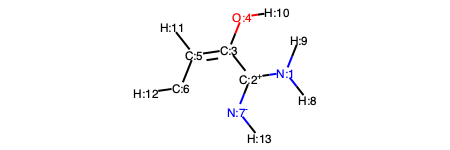

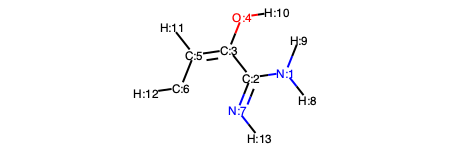

In [24]:
smiles = df_colin.psmi.values[8465]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[N:1]([C:2](/[C:3]([O:4][H:10])=[C:5](\[C:6][H:12])[H:11])=[N:7][H:13])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

[N-:1]([C+:6]1[C:2]([H:9])=[O+:3][C:4]([H:10])([H:11])[C:5]([H:12])([H:13])[N-:7]1)[H:8]


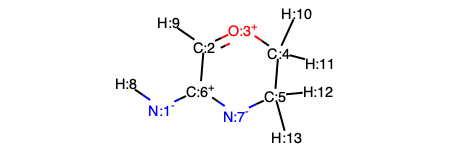

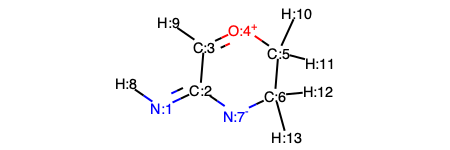

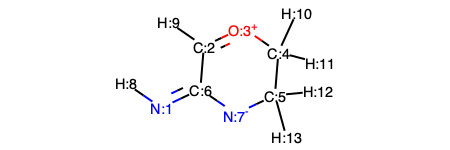

In [29]:
# 11510 in b97d3
smiles = df_colin.psmi.values[8554]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed smiles has wrong atom map
smiles = '[N:1](=[C:2]1[C:3]([H:9])=[O+:4][C:5]([H:10])([H:11])[C:6]([H:12])([H:13])[N-:7]1)[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

smiles = '[N:1](=[C:6]1[C:2]([H:9])=[O+:3][C:4]([H:10])([H:11])[C:5]([H:12])([H:13])[N-:7]1)[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([N+:2]([C:3]([C+:4]([O-:5])[O-:6])([H:12])[H:13])([C:7]([H:14])([H:15])[H:16])[H:11])([H:8])([H:9])[H:10]


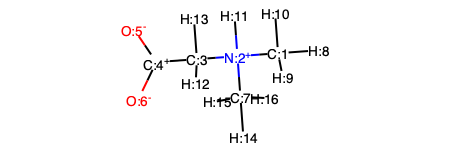

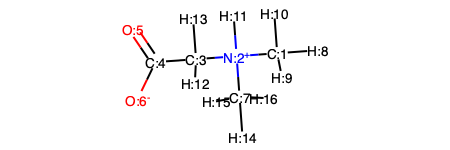

In [30]:
# 11708 in b97d3
smiles = df_colin.psmi.values[8687]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# this is the representative resonance structure
# https://rmg.mit.edu/database/resonance_structure/1%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B14,S%7D%20%7B15,S%7D%20%7B16,S%7D%0A2%20%20N%20u0%20p0%20c+1%20%7B1,S%7D%20%7B3,S%7D%20%7B9,S%7D%20%7B13,S%7D%0A3%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B4,S%7D%20%7B7,S%7D%20%7B8,S%7D%0A4%20%20C%20u0%20p0%20c+1%20%7B3,S%7D%20%7B5,S%7D%20%7B6,S%7D%0A5%20%20O%20u0%20p3%20c-1%20%7B4,S%7D%0A6%20%20O%20u0%20p3%20c-1%20%7B4,S%7D%0A7%20%20H%20u0%20p0%20c0%20%7B3,S%7D%0A8%20%20H%20u0%20p0%20c0%20%7B3,S%7D%0A9%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B10,S%7D%20%7B11,S%7D%20%7B12,S%7D%0A10%20H%20u0%20p0%20c0%20%7B9,S%7D%0A11%20H%20u0%20p0%20c0%20%7B9,S%7D%0A12%20H%20u0%20p0%20c0%20%7B9,S%7D%0A13%20H%20u0%20p0%20c0%20%7B2,S%7D%0A14%20H%20u0%20p0%20c0%20%7B1,S%7D%0A15%20H%20u0%20p0%20c0%20%7B1,S%7D%0A16%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
smiles = '[C:1]([N+:2]([C:3]([C:4](=[O:5])[O-:6])([H:12])[H:13])([C:7]([H:14])([H:15])[H:16])[H:11])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

[C:1]([N:2]([C+:3]([N:4]([H:11])[H:12])[C+:5]([O-:6])[N-:7][H:14])[H:13])([H:8])([H:9])[H:10]


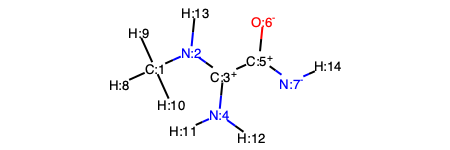

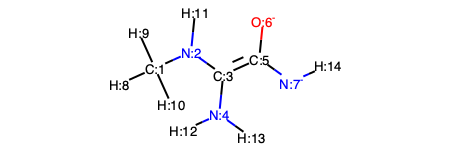

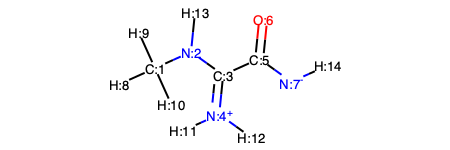

In [32]:
# 11737 in b97d3
smiles = df_colin.psmi.values[8713]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[C:1]([N:2]([C:3]([N:4]([H:12])[H:13])=[C:5]([O-:6])[N-:7][H:14])[H:11])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# use the better resonsance structure
# https://rmg.mit.edu/database/resonance_structure/1%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B12,S%7D%20%7B13,S%7D%20%7B14,S%7D%0A2%20%20N%20u0%20p1%20c0%20%7B1,S%7D%20%7B3,S%7D%20%7B11,S%7D%0A3%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B4,D%7D%20%7B7,S%7D%0A4%20%20N%20u0%20p0%20c+1%20%7B3,D%7D%20%7B5,S%7D%20%7B6,S%7D%0A5%20%20H%20u0%20p0%20c0%20%7B4,S%7D%0A6%20%20H%20u0%20p0%20c0%20%7B4,S%7D%0A7%20%20C%20u0%20p0%20c0%20%7B3,S%7D%20%7B8,D%7D%20%7B9,S%7D%0A8%20%20O%20u0%20p2%20c0%20%7B7,D%7D%0A9%20%20N%20u0%20p2%20c-1%20%7B7,S%7D%20%7B10,S%7D%0A10%20H%20u0%20p0%20c0%20%7B9,S%7D%0A11%20H%20u0%20p0%20c0%20%7B2,S%7D%0A12%20H%20u0%20p0%20c0%20%7B1,S%7D%0A13%20H%20u0%20p0%20c0%20%7B1,S%7D%0A14%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
smiles = '[C:1]([N:2]([C:3](=[N+:4]([H:11])[H:12])[C:5](=[O:6])[N-:7][H:14])[H:13])([H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([O:3][C:5]([C:6]([O:7][H:15])([H:13])[H:14])([H:11])[H:12])[N-:4][H:10])([H:8])[H:9]


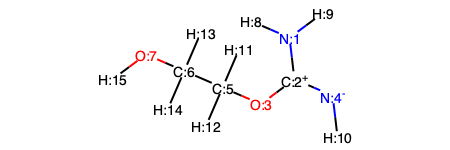

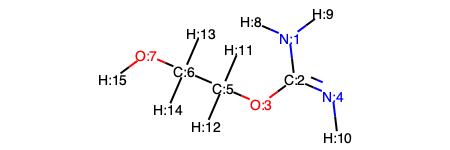

In [33]:
# 11787 in b97d3
smiles = df_colin.psmi.values[8747]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[N:1]([C:2]([O:3][C:5]([C:6]([O:7][H:15])([H:13])[H:14])([H:11])[H:12])=[N:4][H:10])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

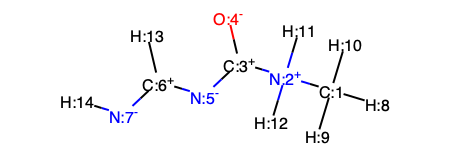

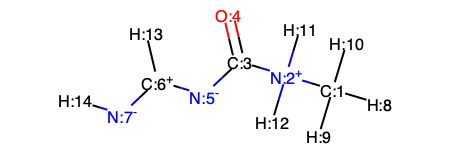

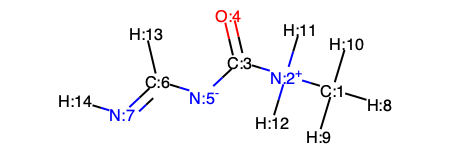

In [37]:
# rxn009001
# original
smiles = '[C:1]([N+:2]([C+:3]([O-:4])[N-:5][C+:6]([N-:7][H:14])[H:13])([H:11])[H:12])([H:8])([H:9])[H:10]'
mol1 = create_rdkit_mol(smiles)

# proposed. correct atom mapping, but not the best resonance 
smiles = '[C:1]([N+:2]([C:3](=[O:4])[N-:5][C+:6]([N-:7][H:14])[H:13])([H:11])[H:12])([H:8])([H:9])[H:10]'
mol2 = create_rdkit_mol(smiles)

# cleaned. 
# https://rmg.mit.edu/database/resonance_structure/1%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B12,S%7D%20%7B13,S%7D%20%7B14,S%7D%0A2%20%20N%20u0%20p0%20c+1%20%7B1,S%7D%20%7B3,S%7D%20%7B10,S%7D%20%7B11,S%7D%0A3%20%20C%20u0%20p0%20c0%20%7B2,S%7D%20%7B4,D%7D%20%7B5,S%7D%0A4%20%20O%20u0%20p2%20c0%20%7B3,D%7D%0A5%20%20N%20u0%20p2%20c-1%20%7B3,S%7D%20%7B6,S%7D%0A6%20%20C%20u0%20p0%20c0%20%7B5,S%7D%20%7B7,D%7D%20%7B9,S%7D%0A7%20%20N%20u0%20p1%20c0%20%7B6,D%7D%20%7B8,S%7D%0A8%20%20H%20u0%20p0%20c0%20%7B7,S%7D%0A9%20%20H%20u0%20p0%20c0%20%7B6,S%7D%0A10%20H%20u0%20p0%20c0%20%7B2,S%7D%0A11%20H%20u0%20p0%20c0%20%7B2,S%7D%0A12%20H%20u0%20p0%20c0%20%7B1,S%7D%0A13%20H%20u0%20p0%20c0%20%7B1,S%7D%0A14%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
smiles = '[C:1]([N+:2]([C:3](=[O:4])[N-:5][C:6](=[N:7][H:14])[H:13])([H:11])[H:12])([H:8])([H:9])[H:10]'
mol3 = create_rdkit_mol(smiles)

[O-:1][C+:6]([N:5]([C:4](=[C:3]([C:2]#[N:7])[H:8])[H:9])[H:10])[H:11]


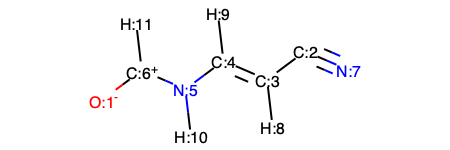

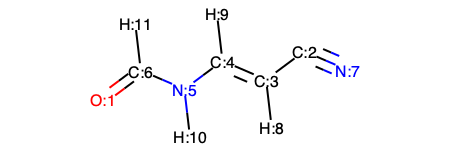

In [39]:
# 12412 in b97d3
smiles = df_colin.psmi.values[9173]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[O:1]=[C:6]([N:5]([C:4](=[C:3]([C:2]#[N:7])[H:8])[H:9])[H:10])[H:11]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

[N-:1]([C+:2]([O-:3])[C:6]#[N+:7][C:4](=[O:5])[H:9])[H:8]


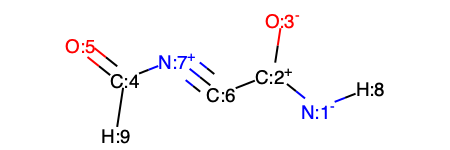

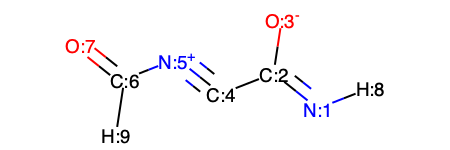

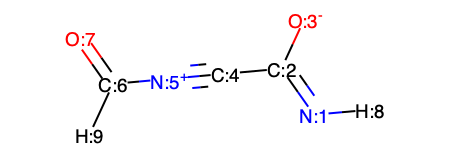

In [41]:
# 12460 in b97d3
smiles = df_colin.psmi.values[9227]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# atom map is out of order in smiles!
smiles = '[N:1](=[C:2]([O-:3])[C:4]#[N+:5][C:6](=[O:7])[H:9])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1](=[C:2]([O-:3])[C:6]#[N+:7][C:4](=[O:5])[H:9])[H:8]'
mol3 = create_rdkit_mol(smiles)

[O:1]([C+:2]([N:3]=[C:4]=[C:6]([O:5][H:9])[H:10])[N-:7][H:11])[H:8]


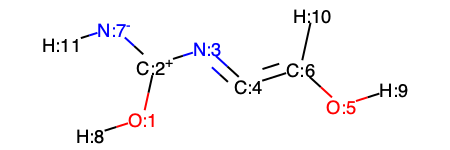

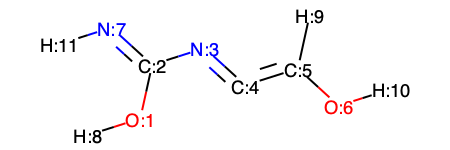

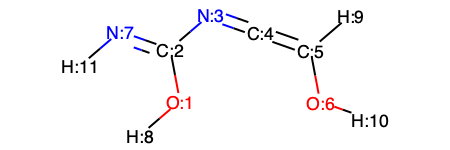

In [44]:
# 12801 in b97d3
smiles = df_colin.psmi.values[9451]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# atom map is incorrect in smiles!
smiles = '[O:1]([C:2]([N:3]=[C:4]=[C:5]([O:6][H:10])[H:9])=[N:7][H:11])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned. 
smiles = '[O:1]([C:2]([N:3]=[C:4]=[C:6]([O:5][H:9])[H:10])=[N:7][H:11])[H:8]'
mol3 = create_rdkit_mol(smiles)

[O:1]([C+:2]1[N-:3][C:4]([O:5][H:9])=[C-:6][N+:7]1([H:10])[H:11])[H:8]


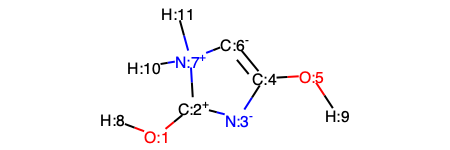

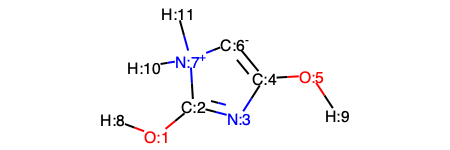

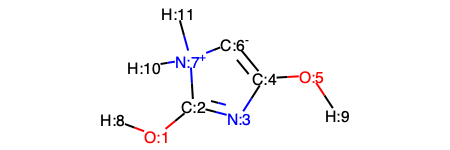

In [46]:
smiles = df_colin.psmi.values[9456]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[O:1]([C:2]1=[N:3][C:4]([O:5][H:9])=[C-:6][N+:7]1([H:10])[H:11])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned. 
smiles = '[O:1]([C:2]1=[N:3][C:4]([O:5][H:9])=[C-:6][N+:7]1([H:10])[H:11])[H:8]'
mol3 = create_rdkit_mol(smiles)

[C-:1]([N:2]([C+:3]1[N-:4][N:5]([H:12])[C+:6]([H:13])[C:7]1([H:8])[H:14])[H:11])([H:9])[H:10]


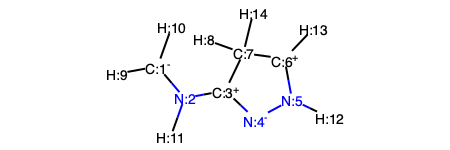

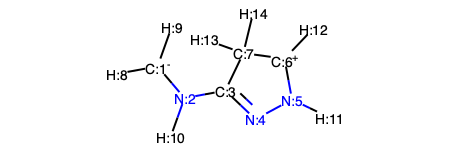

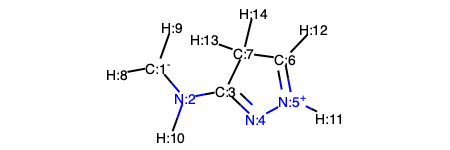

In [51]:
# 12850 in b97d3
smiles = df_colin.psmi.values[9487]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# atom map is incorrect in smiles
smiles = '[C-:1]([N:2]([C:3]1=[N:4][N:5]([H:11])[C+:6]([H:12])[C:7]1([H:13])[H:14])[H:10])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned. 
smiles = '[C-:1]([N:2]([C:3]1=[N:4][N+:5]([H:12])=[C:6]([H:13])[C:7]1([H:8])[H:14])[H:11])([H:9])[H:10]'
mol3 = create_rdkit_mol(smiles)

[N:1]([C+:2]([C:3](=[C:4]=[C:5]([O:6][H:12])[H:11])[H:10])[N-:7][H:13])([H:8])[H:9]


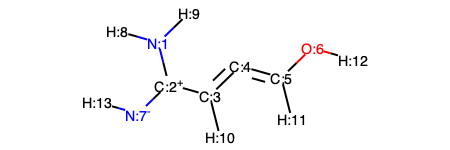

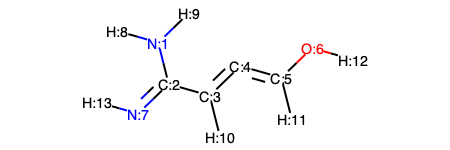

In [55]:
# 13632 in b97d3
smiles = df_colin.psmi.values[10024]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[N:1]([C:2]([C:3](=[C:4]=[C:5]([O:6][H:12])[H:11])[H:10])=[N:7][H:13])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

[C:1]([C:3](=[C:2]=[N:7][C+:5]([N-:4][H:12])[O:6][H:13])[H:11])([H:8])([H:9])[H:10]


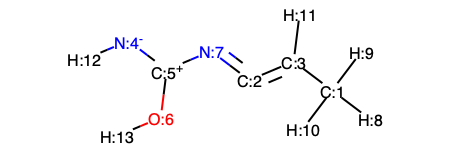

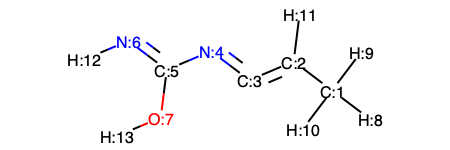

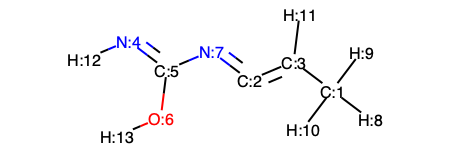

In [62]:
# 14176 in b97d3
smiles = df_colin.psmi.values[10412]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed, wrong atom map
smiles = '[C:1]([C:2](=[C:3]=[N:4][C:5](=[N:6][H:12])[O:7][H:13])[H:11])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned. 
smiles = '[C:1]([C:3](=[C:2]=[N:7][C:5](=[N:4][H:12])[O:6][H:13])[H:11])([H:8])([H:9])[H:10]'
# mol3 = create_rdkit_mol(smiles)
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([C:3](=[C:2]=[C:7]([C+:5]([N-:4][H:12])[N:6]([H:13])[H:14])[H:15])[H:11])([H:8])([H:9])[H:10]


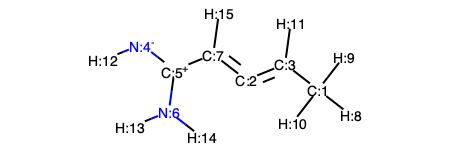

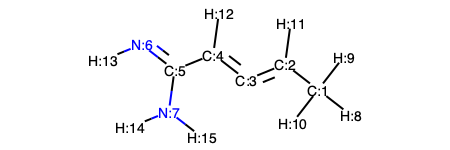

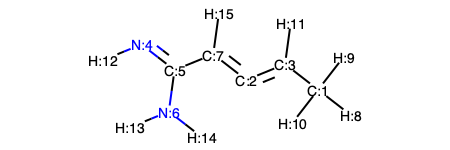

In [65]:
# 14286 in b97d3
smiles = df_colin.psmi.values[10480]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed, wrong atom map!!!
smiles = '[C:1]([C:2](=[C:3]=[C:4]([C:5](=[N:6][H:13])[N:7]([H:14])[H:15])[H:12])[H:11])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned
smiles = '[C:1]([C:3](=[C:2]=[C:7]([C:5](=[N:4][H:12])[N:6]([H:13])[H:14])[H:15])[H:11])([H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
mol3.UpdatePropertyCache()
display(mol3)

[N:1]([C+:2]([N+:3]#[C:4][H:10])[N-:7][N:6]=[N-:5])([H:8])[H:9]


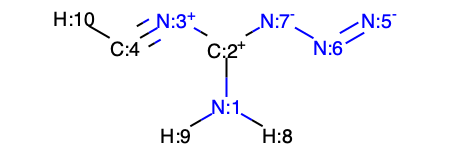

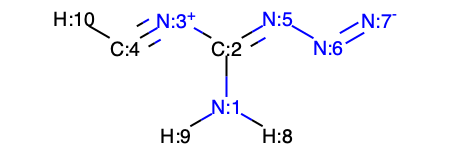

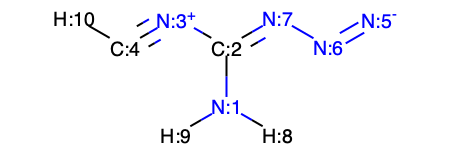

In [68]:
smiles = df_colin.psmi.values[10934]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed, wrong atom map!!!
smiles = '[N:1]([C:2]([N+:3]#[C:4][H:10])=[N:5][N:6]=[N-:7])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned
smiles = '[N:1]([C:2]([N+:3]#[C:4][H:10])=[N:7][N:6]=[N-:5])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
mol3.UpdatePropertyCache()
display(mol3)

[N-:1]([C+:2]1[N-:3][C+:4]([O:5][H:10])[C-:6]([H:11])[N+:7]1([H:9])[H:12])[H:8]


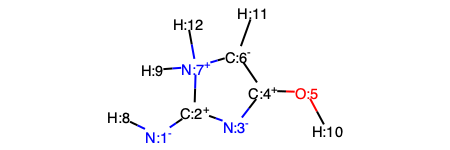

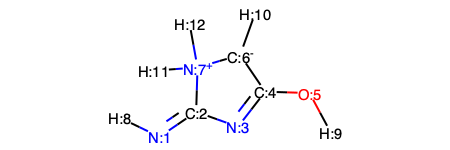

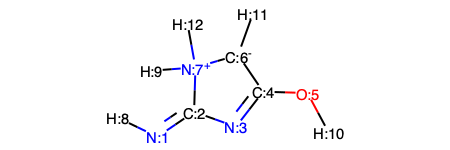

In [89]:
# 15250 in b97d3
smiles = df_colin.psmi.values[11171]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# wrong atom map in smiles!
smiles = '[N:1](=[C:2]1[N:3]=[C:4]([O:5][H:9])[C-:6]([H:10])[N+:7]1([H:11])[H:12])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned
smiles = '[N:1](=[C:2]1[N:3]=[C:4]([O:5][H:10])[C-:6]([H:11])[N+:7]1([H:9])[H:12])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
mol3.UpdatePropertyCache()
display(mol3)

[N:1]([C+:2]([N:3]=[C:4]=[C:6]([O:5][H:10])[H:11])[N-:7][H:12])([H:8])[H:9]


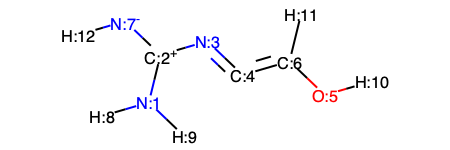

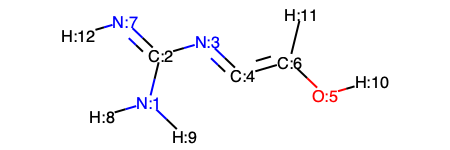

In [73]:
# 15257 in b97d3
smiles = df_colin.psmi.values[11172]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed smiles swaps H atom mapping: '[N:1]([C:2]([N:3]=[C:4]=[C:5]([O:6][H:11])[H:10])=[N:7][H:12])([H:8])[H:9]'
smiles = '[N:1]([C:2]([N:3]=[C:4]=[C:6]([O:5][H:10])[H:11])=[N:7][H:12])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

[N-:1]([C+:2]1[N-:3][C+:4]([O:5][H:10])[C:6]([H:9])([H:11])[N:7]1[H:12])[H:8]


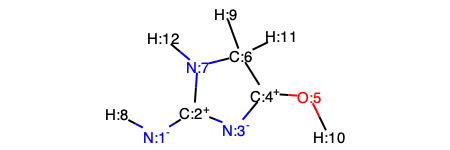

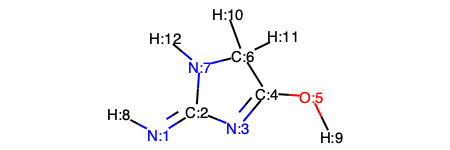

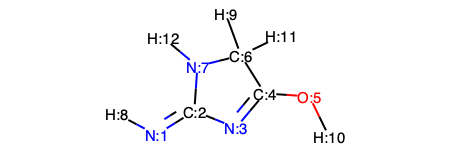

In [75]:
# 15255 in b97d3
smiles = df_colin.psmi.values[11182]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed, swaps H atoms in smiles...
smiles = '[N:1](=[C:2]1[N:3]=[C:4]([O:5][H:9])[C:6]([H:10])([H:11])[N:7]1[H:12])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

smiles = '[N:1](=[C:2]1[N:3]=[C:4]([O:5][H:10])[C:6]([H:9])([H:11])[N:7]1[H:12])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

[N:1]([C+:2]1[N-:3][C+:4]([O:5][H:10])[C:6]([H:11])([H:12])[N-:7]1)([H:8])[H:9]


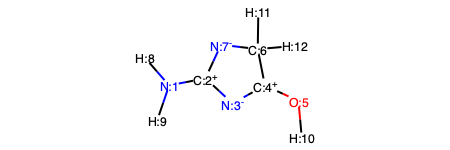

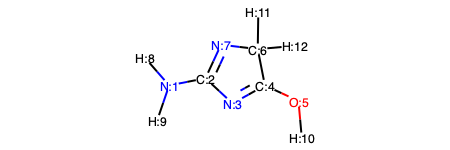

In [78]:
# 15249 in b97d3
smiles = df_colin.psmi.values[11185]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed smiles is correct
smiles = '[N:1]([C:2]=1[N:3]=[C:4]([O:5][H:10])[C:6]([H:11])([H:12])[N:7]1)([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

[N+:1]([c+:2]1[n-:3][o:4][c:5](=[O:6])[n-:7]1)([H:8])([H:9])[H:10]


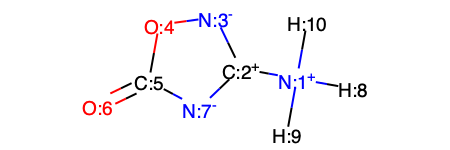

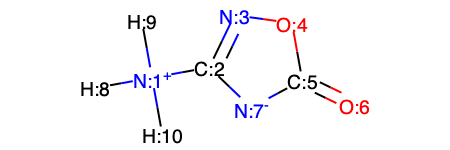

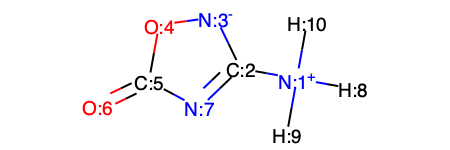

In [80]:
smiles = df_colin.psmi.values[11395]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed smiles has wrong atom..
smiles = '[N+:1]([c:2]1[n-:7][c:5](=[O:6])[o:4][n:3]=1)([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

# cleaned
smiles = '[N+:1]([c:2]1[n-:3][o:4][c:5](=[O:6])[n:7]=1)([H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
mol3.UpdatePropertyCache()
display(mol3)

[N-:1]([C+:2]1[C:3]([H:8])([H:10])[N:4]([H:11])[C+:5]([O:6][H:12])[N-:7]1)[H:9]


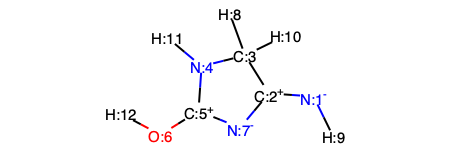

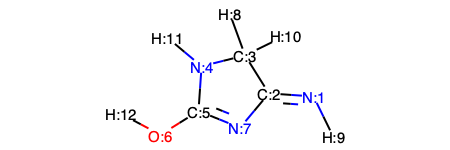

In [83]:
# 16333 in b97d3
smiles = df_colin.psmi.values[11935]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed has wrong H mapping:  '[N:1](=[C:2]1[C:3]([H:9])([H:10])[N:4]([H:11])[C+:5]([O:6][H:12])[N-:7]1)[H:8]'
smiles = '[N:1](=[C:2]1[C:3]([H:8])([H:10])[N:4]([H:11])[C:5]([O:6][H:12])=[N:7]1)[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
mol2.UpdatePropertyCache()
display(mol2)

[C:1]([N+:2]([C+:3]([O-:4])[N-:5][C+:6]([N-:7][H:14])[H:13])([H:11])[H:12])([H:8])([H:9])[H:10]


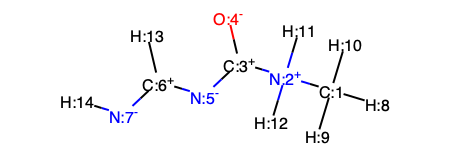

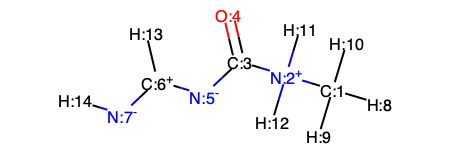

In [35]:
# 11787 in b97d3
smiles = df_colin.psmi.values[9001]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

smiles = '[C:1]([N+:2]([C:3](=[O:4])[N-:5][C+:6]([N-:7][H:14])[H:13])([H:11])[H:12])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

In [73]:
def create_rdkit_mol(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    mol = Chem.AddHs(mol)
    # out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    display(mol)
    
    return mol

In [75]:
def create_rdkit_mol(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    mol = Chem.AddHs(mol)
    # out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    display(mol)
    
    return mol